# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
#from pyspark import SparkFiles
#from pyspark.sql.functions import avg, col, concat, count, desc, \
#asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
#log, sqrt, cbrt, exp, sum

from pyspark.ml import Pipeline, PipelineModel 
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
import tqdm
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
# create a Spark session
def create_spark_session():
    '''
    Create a spark session
    INPUT
    spark session builder
    OUTPUT
    spark object
    '''
    spark = SparkSession\
    .builder \
    .master("local") \
    .appName("sparkify") \
    .config("config option", "config value")\
    .getOrCreate()
    print('Spark parameters:')
    for parameter in spark.sparkContext.getConf().getAll():
        print(parameter)

    return spark

In [3]:
start = time.time()
spark = create_spark_session()
stop = time.time()
print(f'\n Creating spark session time: {round((stop - start)/60, 2)} minutes')

Spark parameters:
('spark.master', 'local')
('spark.app.name', 'sparkify')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('config option', 'config value')
('spark.executor.id', 'driver')
('spark.submit.deployMode', 'client')
('spark.driver.host', 'c90994f83206')
('spark.ui.showConsoleProgress', 'true')
('spark.app.id', 'local-1633380798879')
('spark.driver.port', '44031')

 Creating spark session time: 0.18 minutes


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
def load_dataset(spark, path = 'mini_sparkify_event_data.json'):
    '''
    Data loader
    INPUT
    spark object
    data path
    OUTPUT
    spark dataframe
    '''
    print(f'\nReadinng File from: {path}')
    df = spark.read.json(path)
    print(f'\nColumns in dataset:')
    for column in df.columns:
        print(column)
    print(f'\nDatatypes in dataset: {df.persist()}')
    print(f'\nFirst DataFrame record: {df.head()}')

    return df


def create_nan_dict(df):
    '''
    Description: Gets a spark dataframe and returns a python dictionary with  sum of null values
    Input: Spark DataFrame
    Output: Ordered dicronary ranging from the highest number of nulls to the lowest
    
    '''
    
    # create a dictionary keeping column names and nans
    nan_dict = {}
    for col in df.columns:
        nan_dict[col] = df.where(df[col].isNull()|F.isnan(df[col])).select(col).count()
        
        sorted_dict = dict(sorted(nan_dict.items(), key=lambda item: item[1]))
        # plot Null values
    sns.barplot([*sorted_dict.keys()],[*sorted_dict.values()])
    plt.title('NaN per Column')
    plt.xlabel('Dataset Column')
    plt.ylabel('NaN Count')
    plt.xticks(rotation = 90)
    plt.yticks()
    plt.show();
    
    return sorted_dict

def clean_dataset(df):
    '''
    Data Cleaning
    INPUT
    Spark DataFrame
    OUTPUT
    Cleaned Spark DataFrame
    '''
    log_events = df.dropna(how = "any", subset = ["firstName"])
    log_events = log_events.withColumn('song', F.when(log_events.song.isNull(), F.lit("no_song")).otherwise(df.song))
    log_events = log_events.withColumn('artist', F.when(log_events.artist.isNull(), F.lit("no_artist")).otherwise(df.artist))
    log_events = log_events.withColumn('length', F.when(log_events.length.isNull(), F.lit(0)).otherwise(df.length))

    return log_events


Readinng File from: mini_sparkify_event_data.json

Columns in dataset:
artist
auth
firstName
gender
itemInSession
lastName
length
level
location
method
page
registration
sessionId
song
status
ts
userAgent
userId

Datatypes in dataset: DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

First DataFrame record: Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')


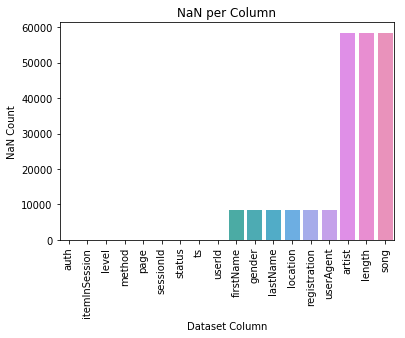


 Loading dataset time: 0.61 minutes

 Cleaning dataset time: 0.01 minutes


In [5]:
start = time.time()
df = load_dataset(spark)
nan_dict = create_nan_dict(df)
stop = time.time()
print(f'\n Loading dataset time: {round((stop - start)/60, 2)} minutes')

start = time.time()
log_events = clean_dataset(df)
stop = time.time()
print(f'\n Cleaning dataset time: {round((stop - start)/60, 2)} minutes')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
def down_selection(page):
    '''
    helper funcction to create churn double selection downgrade
    INPUT
    page column
    OUTPUT
    no output
    '''
    if page == 'Cancellation Confirmation' or page == 'Downgrade':
        return 1
    return 0

def create_churn_col(log_events):
    '''
    create churn column in log_events Spark DataFrame
    INPUT
    log_events DataFrame
    OUTPUT
    log_events DataFrame with churn column
    '''
    flag_downgrade_event = F.udf(down_selection, IntegerType())

    log_events = log_events.withColumn('churn',flag_downgrade_event(df['page']))

    return log_events

def create_phase_col(log_events):
    '''
    create phase column in log_events Spark DataFrame
    INPUT
    log_events DataFrame
    OUTPUT
    log_events DataFrame with phase column
    '''

    # for each user order actions between certain events
    windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

    log_events = log_events.withColumn("phase", F.sum("churn").over(windowval))

    return log_events

In [7]:
start = time.time()
log_events = clean_dataset(df)
log_events = create_churn_col(log_events)
log_events = create_phase_col(log_events)
stop = time.time()
print(f'\n Cleaning dataset time: {round((stop - start)/60, 2)} minutes')


 Cleaning dataset time: 0.01 minutes


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [8]:
def get_device_col(log_events):
    '''
    create device column in log_events Spark DataFrame
    INPUT
    log_events DataFrame
    OUTPUT
    log_events DataFrame with device column
    '''
    get_device = F.udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

    log_events = log_events.withColumn("device", get_device(log_events["userAgent"]))
    return log_events

def create_num_df(log_events):
    '''
    aggregate numeric featuresin the log_events Spark DataFrame
    INPUT
    log_events DataFrame
    OUTPUT
    separate dataframe containing only numeric Features
    '''
    num_df = log_events.select("userId","itemInSession", "phase", "length")\
    .groupBy("userId")\
    .agg(F.count(log_events.userId).cast('int').alias("count_user_logs"),\
        F.max(log_events.itemInSession).cast('int').alias("max_session"),\
        #F.avg(log_events.phase).cast('int').alias("avg_phase"),\
        F.avg(log_events.length).cast('int').alias("avg_length"))

    return num_df


def fix_log_events_dtype(log_events):
    log_events = log_events.withColumn('status', F.col('status').cast('string'))
    
    return log_events


def rename_columns(log_events):
    get_location = F.udf(lambda location: location.split(", ")[-1])
    log_events = log_events.withColumn("location", get_location(log_events['location']))
    
    get_page = F.udf(lambda page: page.replace(' ', '_').lower())
    log_events = log_events.withColumn("page", get_page(log_events['page']))
    
    return log_events
    
def get_dummy_expression(column):
    '''
    create expressions to separate Categorical Features 
    INPUT
    One column of the log_events DataFrame
    OUTPUT
    the expression to be used
    '''
    unique_values = log_events.select(column).distinct().rdd.flatMap(lambda element:element).collect()
    expression = [F.when(F.col(column) == col_el, 1).otherwise(0).alias(column + "_" + col_el) for col_el in unique_values]

    return expression

def create_bins_n_sums(log_events):
    """
    we need to know which columns to keep as binary and which ones we have to summarize and get the sum of values 
    for each userId, to later know if we have to use get_sum_df() or get_bin_df() functions. If the lenght of userId logs
    is the same with column unique featue such as gender or device we need to create a binary feature. Otherwise we need
    to aggregate accordingly and treat the feature as numeric 
    """
    string_cols = string_cols = [item[0] for item in log_events.dtypes if item[0]\
               not in ['firstName', 'lastName', 'artist', 'song', 'userId', 'userAgent']\
               and item[1].startswith('string')]
    bin_cols = []
    sum_cols = []
    id_count = len(log_events.dropDuplicates()\
                            .groupBy('userId')\
                            .count()\
                            .collect())

    for colm in string_cols:
        col_count = len(log_events.dropDuplicates().select('userId',colm).groupBy('userId', colm).agg(F.count(colm)).collect())
        
        if id_count == col_count:
            bin_cols.append(colm)
        else:
            sum_cols.append(colm)
            
    return bin_cols, sum_cols

def create_sum_df(log_events, column):
    expression = get_dummy_expression(column)
    cat_df = log_events.select(log_events.userId, *expression)
    cat_df = cat_df.groupBy("userId").sum()
   
    for colm in cat_df.columns:
        if colm != "userId":
            cat_df = cat_df.withColumn(colm, F.col(colm).cast('int')).withColumnRenamed(colm, colm[4:-1])

    return cat_df

def create_bin_df(log_events, column):
    expression = get_dummy_expression(column)
    bin_df = log_events.select(log_events.userId, *expression)
    bin_df = bin_df.groupBy("userId").avg()
   
    for colm in bin_df.columns:
        if colm != "userId":
            bin_df = bin_df.withColumn(colm, F.col(colm).cast('int')).withColumnRenamed(colm, colm[4:-1])

    return bin_df

def transform_the_cats(log_events):

    device_df = create_bin_df(log_events, 'device')
    
    #get_location = F.udf(lambda location: location.split(", ")[-1])
    #log_events = log_events.withColumn("location", get_location(log_events['location']))
    location_df = create_bin_df(log_events, 'location')
    gender_df = create_bin_df(log_events, 'gender')

    
    pages_df = create_sum_df(log_events, 'page')
    pages_df = pages_df.drop('page_Cancellation_Confirmation', 'page_Downgrade')
    
    status_df = create_sum_df(log_events, 'status')
    auth_df = create_sum_df(log_events, 'auth')

    level_df = create_sum_df(log_events, 'level')
    method_df = create_sum_df(log_events, 'method')
    
    return device_df, location_df, pages_df, status_df, auth_df, gender_df, level_df, method_df


def fix_cat_dtype(cat_df):
    '''
    fix data type in cat_df
    
    INPUT
    cat_df Spark DataFrame
    
    OUTPUT
    cat_df Spark DataFrame
    '''
    for col in cat_df.columns:
        if col != "userID":
            cat_df = cat_df.withColumn(col, F.col(col).cast("int"))
        
    return cat_df


def create_cat_dict(cat_df):
    keywords = ['device', 'locations', 'page', 'status', 'auth', 'gender', 'level', 'method']
    cat_dict = {}
    for wrd in keywords:
        if wrd not in ['page_Cancellation_Confirmation', 'page_Downgrade']:
            col_names = [col for col in cat_df.columns if wrd in col] + ['userId']
            cat_dict[wrd + '_df'] = col_names
        
    return cat_dict

def data_for_modeling(log_events, num_df, pages_df, gender_df):
    churn_func = F.udf(lambda x: 0 if x == 0 else 1)
    churn_vals = log_events\
        .select('userId','churn')\
        .groupBy('userId').sum()\
        .withColumnRenamed("sum(churn)", "sum_churn")\
        .withColumn('churn_bin', churn_func('sum_churn'))

    data = num_df\
        .join(pages_df, ["userID"])\
        .join(gender_df, ["userID"])\
        .join(churn_vals.select('userID','churn_bin'), ["userID"])

    # Rename churn column into label
    data = data.withColumn('label', data['churn_bin'].cast('float')).drop('churn_bin') #important to have float type
    data = fix_cat_dtype(data)
    # Feature columns to be converted into vector
    cols = data.drop('label').drop('userId').columns

    # Train-test split
    train, test = data.drop('userId').randomSplit([0.6, 0.4], seed = 42)
    
    return churn_vals, data, cols, train, test

In [9]:
start = time.time()
log_events = fix_log_events_dtype(log_events)
print(f'Fixed data Types')
log_events = rename_columns(log_events)
print(f'Renamed Columns')
num_df = create_num_df(log_events)
print(f'Created Numeric Features')
log_events = get_device_col(log_events)
print(f'Created device Column')


bin_cols, sum_cols = create_bins_n_sums(log_events)
print(f'Separating categorical columns into:\
\nBinary Features to keep as is: {bin_cols} \
\nFeatures to aggregate: {sum_cols}')

device_df, location_df, pages_df, status_df, auth_df, gender_df, level_df, method_df = transform_the_cats(log_events)
print(f'Fixed Categorical Features')

stop = time.time()
print(f'\nTime: {round((stop - start)/60, 2)} minutes')

start = time.time()
churn_vals,\
data,\
cols,\
train,\
test = data_for_modeling(log_events, num_df, pages_df, gender_df)
stop = time.time()
print(f'\n Joining Features Together: {round((stop - start)/60, 2)} minutes')

Fixed data Types
Renamed Columns
Created Numeric Features
Created device Column
Separating categorical columns into:
Binary Features to keep as is: ['gender', 'location', 'device'] 
Features to aggregate: ['auth', 'level', 'method', 'page', 'status']
Fixed Categorical Features

Time: 7.08 minutes

 Joining Features Together: 0.01 minutes


#### Save data in `.parquet` 

In [10]:
data.write.mode('overwrite').save('data.parquet')

In [11]:
churn_vals.write.mode('overwrite').save("churn_vals.parquet")

In [12]:
train.write.mode('overwrite').save("train.parquet")

In [13]:
test.write.mode('overwrite').save("test.parquet")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [4]:
def build_pipeline(classifier, paramGrid):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: K-fold cross validator performing model selection by splitting
    the dataset into a set of non-overlapping randomly partitioned folds which
    are used as separate training and test datasets
    e.g., with k=3 folds, K-fold cross validation will generate 3 (training, test)
    dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing
    '''
    # feature transformer that merges multiple columns into a vector column
    assembler = VectorAssembler(inputCols = cols, outputCol = "features")
    #mascaler = MaxAbsScaler(inputCol = "features", outputCol = "scaled")
    #mmScaler = MinMaxScaler(inputCol = "features", outputCol = "scaled")
    sdscaler = StandardScaler(inputCol = "features", outputCol = "scaled", withStd=True, withMean=True)
    pipeline = Pipeline(stages = [assembler, sdscaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = paramGrid,
        evaluator = MulticlassClassificationEvaluator(metricName='f1'),
        numFolds = 3
    )
    return crossval

def train_model(classifier, train, paramGrid):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train: Spark DataFrame to use for training
    
    OUTPUT
    model: trained machine learning model
    training_time: excecution time
    '''
    crossval = build_pipeline(classifier, paramGrid)
    start = time.time()
    
    model = crossval.fit(train)
    stop = time.time()
    training_time = round((stop - start)/60, 2)
    print(f'Training time: {training_time} minutes')
    
    return model, training_time

def evaluate_model(model, testset):
    
    start = time.time()
    # make prediction yhat
    yhat = model.transform(testset)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    
    stop = time.time()
    eval_time = round((stop - start)/60, 2)
    print(f'Evaluation time: {eval_time} minutes')
    
    return yhat, evaluator

def results_classifier(lr = False, rf = False):

    if lr:
        classifier = LogisticRegression(labelCol="label", featuresCol="scaled")
    elif rf:
        classifier = RandomForestClassifier(labelCol="label", featuresCol="scaled")
    else:
        classifier = GBTClassifier(labelCol="label", featuresCol="scaled")
    paramGrid = ParamGridBuilder().build() # build parameters
    model, training_time = train_model(classifier, train, paramGrid) # train model on train set
    yhat_test, test_evaluator = evaluate_model(model, test) # make predictions from test set
    best_model = model.bestModel # save the best model of the pipeline
    
    return test_evaluator, yhat_test, best_model

def save_metrics(evaluator, yhat_test, lr = False, rf = False):
    metrics = {}
    metrics['f1'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "f1"})
    metrics['accuracy'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "accuracy"})
    metrics['weighted_precision'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "weightedPrecision"})
    metrics['weighted_recall'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "weightedRecall"})
    metrics_df = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['metrics'])
    conf_matrix = yhat_test.groupby("label").pivot("prediction").count().toPandas()
    
    if lr:
        metrics_df.to_csv('lr_metrics' + '.csv', index = True)
        conf_matrix.to_csv('lr_cm' + '.csv', index = True)
    elif rf:
        metrics_df.to_csv('rf_metrics' + '.csv', index = True)
        conf_matrix.to_csv('rf_cm' + '.csv', index = True)
    else:
        metrics_df.to_csv('gbt_metrics' + '.csv', index = True)
        conf_matrix.to_csv('gbt_cm' + '.csv', index = True)
    
    return metrics_df, conf_matrix

def calculate_logloss(df):

    # extract predicted probability
    get_first_element = F.udf(lambda v:float(v[1]), FloatType())
    df = df.withColumn("preds", get_first_element(F.col("probability")))

    # calculate negative log-likelihood
    y1, y0 = F.col("label"), 1 - F.col("label")
    p1, p0 = F.col("preds"), 1 - F.col("preds")
    nll = -(y1*F.log(p1) + y0*F.log(p0))

    # aggregate
    return df.agg(F.mean(nll)).collect()[0][0]

def save_logloss_vals(rf_yhat_test, lr_yhat_test, gbt_yhat_test, grid_yhat_test):
    logloss = {}
    logloss['rf'] = calculate_logloss(rf_yhat_test)
    logloss['lr'] = calculate_logloss(lr_yhat_test)
    logloss['gbt'] = calculate_logloss(gbt_yhat_test)
    logloss['grid'] = calculate_logloss(grid_yhat_test)
    logloss_df = pd.DataFrame.from_dict(logloss, orient = 'index', columns = ['logloss'])
    logloss_df.to_csv('logloss.csv', index = True)
    
    return logloss

def create_coef_df(cols, lr, rf, gbt, grid):
    
    lr_feature_coef = lr.stages[2].coefficients.values.tolist()
    lr_dict = dict(list(zip(cols, lr_feature_coef)))
    lr_df = pd.DataFrame.from_dict(lr_dict, orient = 'index', columns = ['coefficient'])\
    .sort_values('coefficient', ascending=False)
    
    rf_feature_coef = rf.stages[2].featureImportances.values.tolist()
    rf_dict = dict(list(zip(cols, rf_feature_coef)))
    rf_df = pd.DataFrame.from_dict(rf_dict, orient = 'index', columns = ['coefficient'])\
    .sort_values('coefficient', ascending=False)
    
    gbt_feature_coef = gbt.stages[2].featureImportances.values.tolist()
    gbt_dict = dict(list(zip(cols, gbt_feature_coef)))
    gbt_df = pd.DataFrame.from_dict(gbt_dict, orient = 'index', columns = ['coefficient'])\
    .sort_values('coefficient', ascending=False)
    
    grid_feature_coef = grid.stages[2].featureImportances.values.tolist()
    grid_dict = dict(list(zip(cols, rf_feature_coef)))
    grid_df = pd.DataFrame.from_dict(rf_dict, orient = 'index', columns = ['coefficient'])\
    .sort_values('coefficient', ascending=False)
    
    return lr_df, rf_df, gbt_df, grid_df

def plot_coef(df, title):

    plt.figure(figsize=(30, 15))
    sns.barplot(x = df.index, y = df.coefficient, data = df)
    plt.title(title, fontsize = 40)
    plt.xlabel('Features', fontsize = 30)
    plt.ylabel('Feature Importance', fontsize = 30)
    plt.xticks(rotation = 60, fontsize = 20)
    plt.yticks(fontsize = 14)
    plt.show()


In [5]:
def results_rf_classifier():

    classifier = RandomForestClassifier(labelCol="label", featuresCol="scaled")
    
    paramGrid = ParamGridBuilder()\
        .addGrid(classifier.numTrees, [5, 10, 20, 25, 30, 50, 100])\
        .build() # build parameters
    crossval, training_time = train_model(classifier, train, paramGrid) # train model on train set
    grid_yhat_test, grid_evaluator = evaluate_model(crossval, test) # make predictions from test set
    best_model = crossval.bestModel # save the best model of the pipeline
    
    return crossval, grid_evaluator, grid_yhat_test, best_model

In [6]:
def save_rf_metrics(evaluator, yhat_test):
    metrics = {}
    metrics['f1'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "f1"})
    metrics['accuracy'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "accuracy"})
    metrics['weighted_precision'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "weightedPrecision"})
    metrics['weighted_recall'] = evaluator.evaluate(yhat_test, {evaluator.metricName: "weightedRecall"})
    metrics_df = pd.DataFrame.from_dict(metrics, orient = 'index', columns = ['metrics'])
    conf_matrix = yhat_test.groupby("label").pivot("prediction").count().toPandas()
    
    metrics_df.to_csv('rf_grid_metrics.csv', index = True)
    conf_matrix.to_csv('rf_grid_cm.csv', index = True)
    
    return metrics_df, conf_matrix

#### Load `.parquet` files

In [7]:
data = spark.read.load("data.parquet")
churn_vals = spark.read.load("churn_vals.parquet")
train = spark.read.load("train.parquet")
test = spark.read.load("test.parquet")
cols = data.drop('label').drop('userId').columns

#### Train with the power of `.parquet`

In [8]:
rf_test_evaluator, rf_yhat_test, rf = results_classifier(rf = True)

Training time: 0.64 minutes
Evaluation time: 0.0 minutes


In [9]:
lr_test_evaluator, lr_yhat_test, lr = results_classifier(lr = True)

Training time: 0.44 minutes
Evaluation time: 0.0 minutes


In [10]:
gbt_test_evaluator, gbt_yhat_test, gbt = results_classifier()

Training time: 1.21 minutes
Evaluation time: 0.0 minutes


In [11]:
crossval, grid_evaluator, grid_yhat_test, grid_best_model = results_rf_classifier()

Training time: 0.9 minutes
Evaluation time: 0.0 minutes


#### Calculate metrics

In [12]:
rf_metrics, rf_matrix = save_metrics(rf_test_evaluator, rf_yhat_test, rf = True)

In [13]:
lr_metrics, lr_matrix = save_metrics(lr_test_evaluator, lr_yhat_test, lr = True)

In [14]:
gbt_metrics, gbt_matrix = save_metrics(gbt_test_evaluator, gbt_yhat_test)

In [15]:
rf_grid_metrics, rf_grid_matrix = save_rf_metrics(grid_evaluator, grid_yhat_test)

In [16]:
rf_metrics

,metrics
f1,0.903614
accuracy,0.903614
weighted_precision,0.903614
weighted_recall,0.903614


In [17]:
lr_metrics

,metrics
f1,0.893660
accuracy,0.891566
weighted_precision,0.898371
weighted_recall,0.891566


In [18]:
gbt_metrics

,metrics
f1,0.890746
accuracy,0.891566
weighted_precision,0.890243
weighted_recall,0.891566


In [19]:
rf_grid_metrics

,metrics
f1,0.903614
accuracy,0.903614
weighted_precision,0.903614
weighted_recall,0.903614


In [20]:
grid_best_model.stages[2].extractParamMap()

{Param(parent='RandomForestClassifier_033c345547db', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_033c345547db', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_033c345547db', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_033c345547db', name='featuresCol', doc='features column name'): 'scaled',
 Param(parent='RandomForestClassifier_033c345547db', na

In [21]:
crossval.extractParamMap()

{Param(parent='CrossValidatorModel_66e9ee91260b', name='seed', doc='random seed.'): 7681955581229558475,
 Param(parent='CrossValidatorModel_66e9ee91260b', name='estimator', doc='estimator to be cross-validated'): Pipeline_e86f769edffc,
 Param(parent='CrossValidatorModel_66e9ee91260b', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='RandomForestClassifier_033c345547db', name='numTrees', doc='Number of trees to train (>= 1).'): 5},
  {Param(parent='RandomForestClassifier_033c345547db', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  {Param(parent='RandomForestClassifier_033c345547db', name='numTrees', doc='Number of trees to train (>= 1).'): 20},
  {Param(parent='RandomForestClassifier_033c345547db', name='numTrees', doc='Number of trees to train (>= 1).'): 25},
  {Param(parent='RandomForestClassifier_033c345547db', name='numTrees', doc='Number of trees to train (>= 1).'): 30},
  {Param(parent='RandomForestClassifier_033c345547db', name='numTrees'

#### Save DataFrames keeping `Label`, `rawPrediction`, `probability` and `prediction` values

In [22]:
rf_yhat_test.select("label", "rawPrediction", "probability", "prediction").write.mode('overwrite').save("rf_preds.parquet")

In [23]:
lr_yhat_test.select("label", "rawPrediction", "probability", "prediction").write.mode('overwrite').save("lr_preds.parquet")

In [24]:
gbt_yhat_test.select("label", "rawPrediction", "probability", "prediction").write.mode('overwrite').save("gbt_preds.parquet")

In [25]:
grid_yhat_test.select("label", "rawPrediction", "probability", "prediction")\
    .write.mode('overwrite').save("rf_grid_preds.parquet")

#### Load from `.parquet` files

In [26]:
rf_yhat_test = spark.read.load("rf_preds.parquet")

In [27]:
lr_yhat_test = spark.read.load("lr_preds.parquet")

In [28]:
gbt_yhat_test = spark.read.load("gbt_preds.parquet")

In [29]:
grid_yhat_test = spark.read.load("rf_grid_preds.parquet")

#### Calculate LogLoss

In [30]:
logloss_dict = save_logloss_vals(rf_yhat_test, lr_yhat_test, gbt_yhat_test, grid_yhat_test)

In [31]:
logloss_dict

{'rf': 0.24331184800418246,
 'lr': 10.990544194361663,
 'gbt': 0.3260454592217635,
 'grid': 0.24331184800418246}

#### Save models

In [32]:
lr.write().overwrite().save('logistic')
rf.write().overwrite().save('random_forest')
gbt.write().overwrite().save('gradient_boosted_tree')
grid_best_model.write().overwrite().save('grid')

In [33]:
lr = PipelineModel.load("logistic")
rf = PipelineModel.load("random_forest")
gbt = PipelineModel.load("gradient_boosted_tree")
grid = PipelineModel.load("grid")

In [34]:
lr_df, rf_df, gbt_df, grid_df = create_coef_df(cols, lr, rf, gbt, grid)

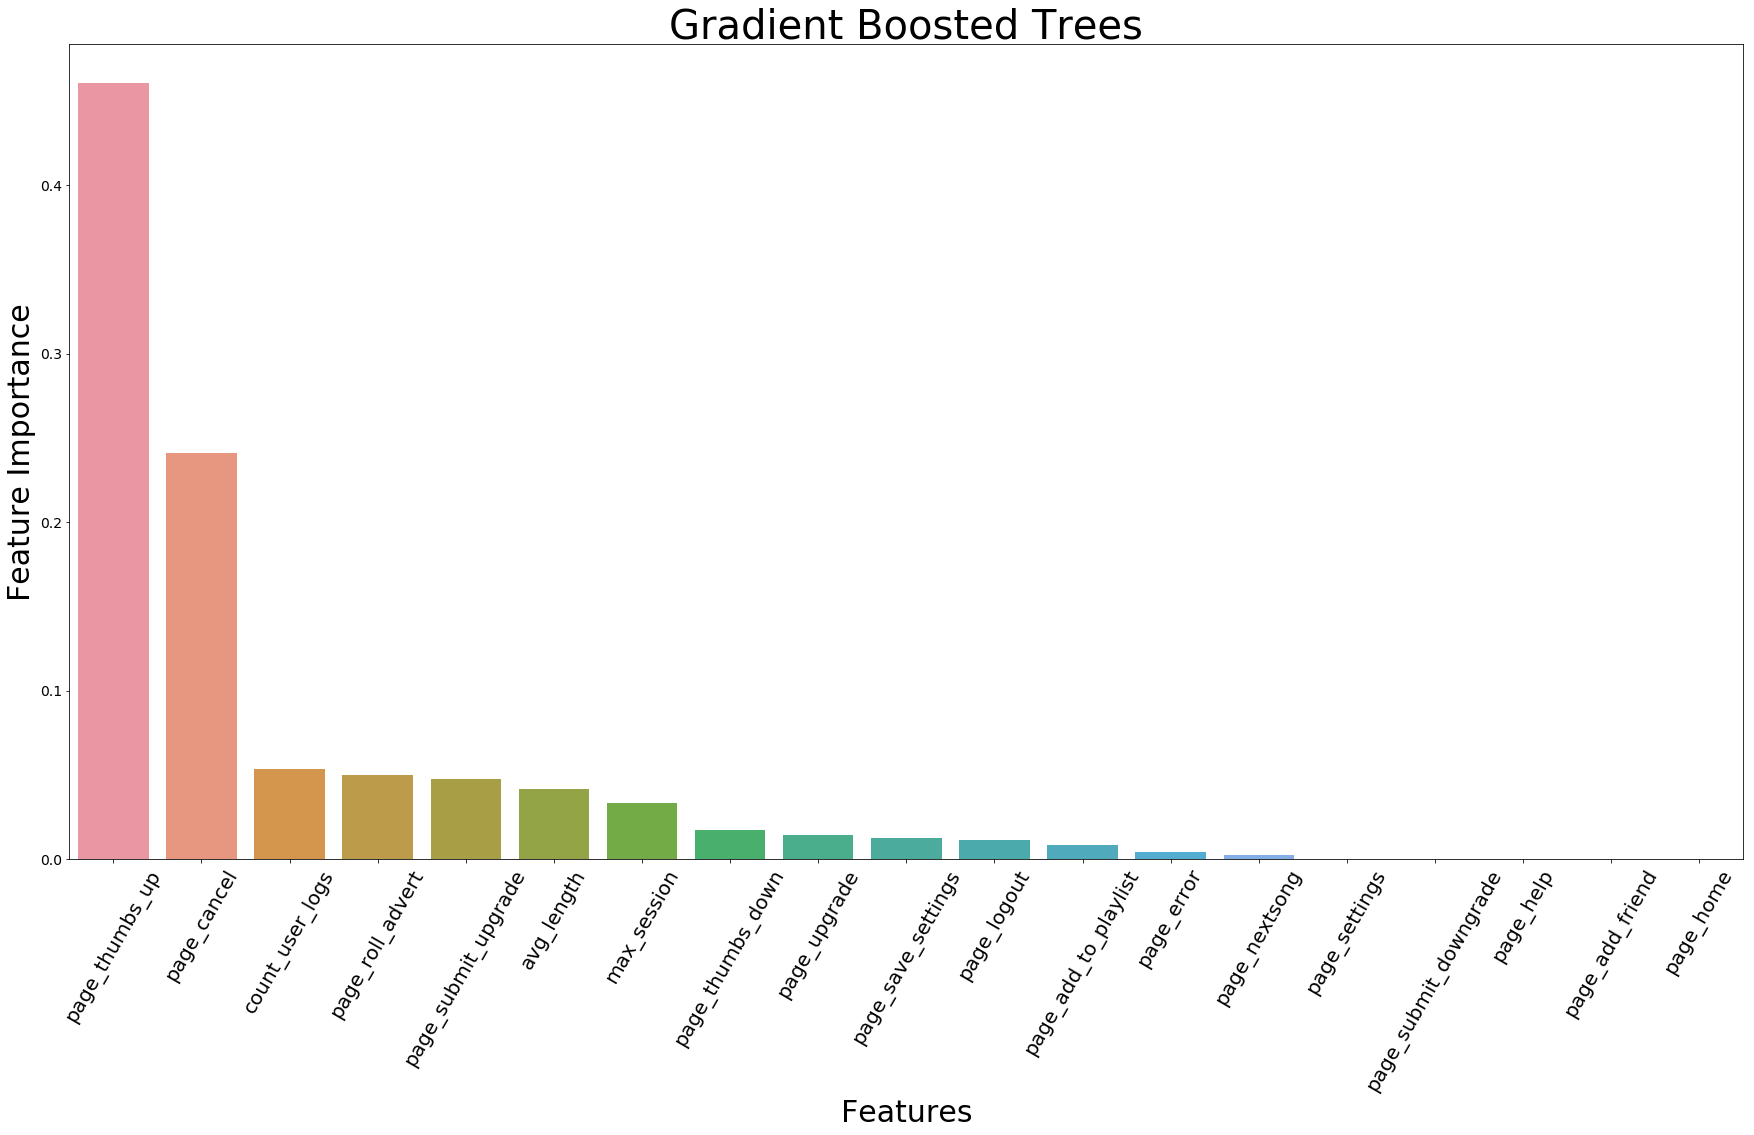

In [35]:
plot_coef(gbt_df, "Gradient Boosted Trees")

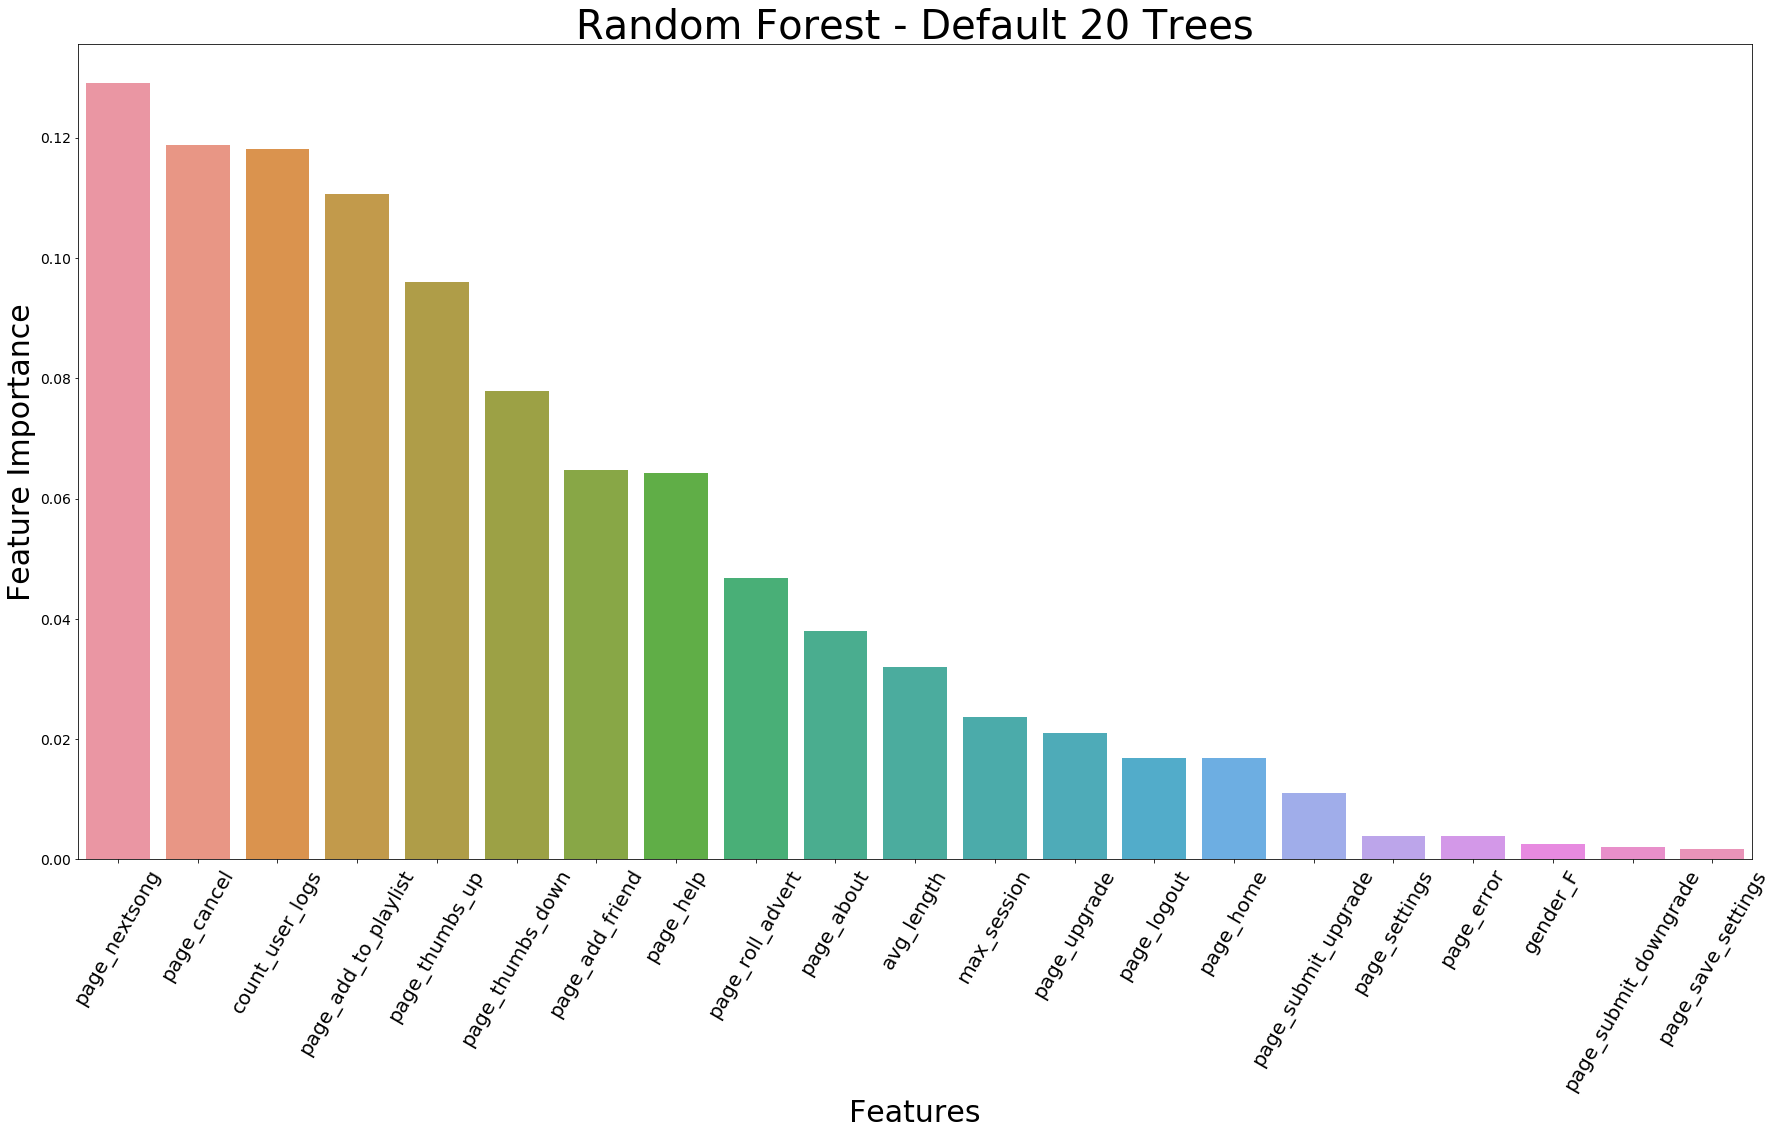

In [36]:
plot_coef(rf_df, "Random Forest - Default 20 Trees")

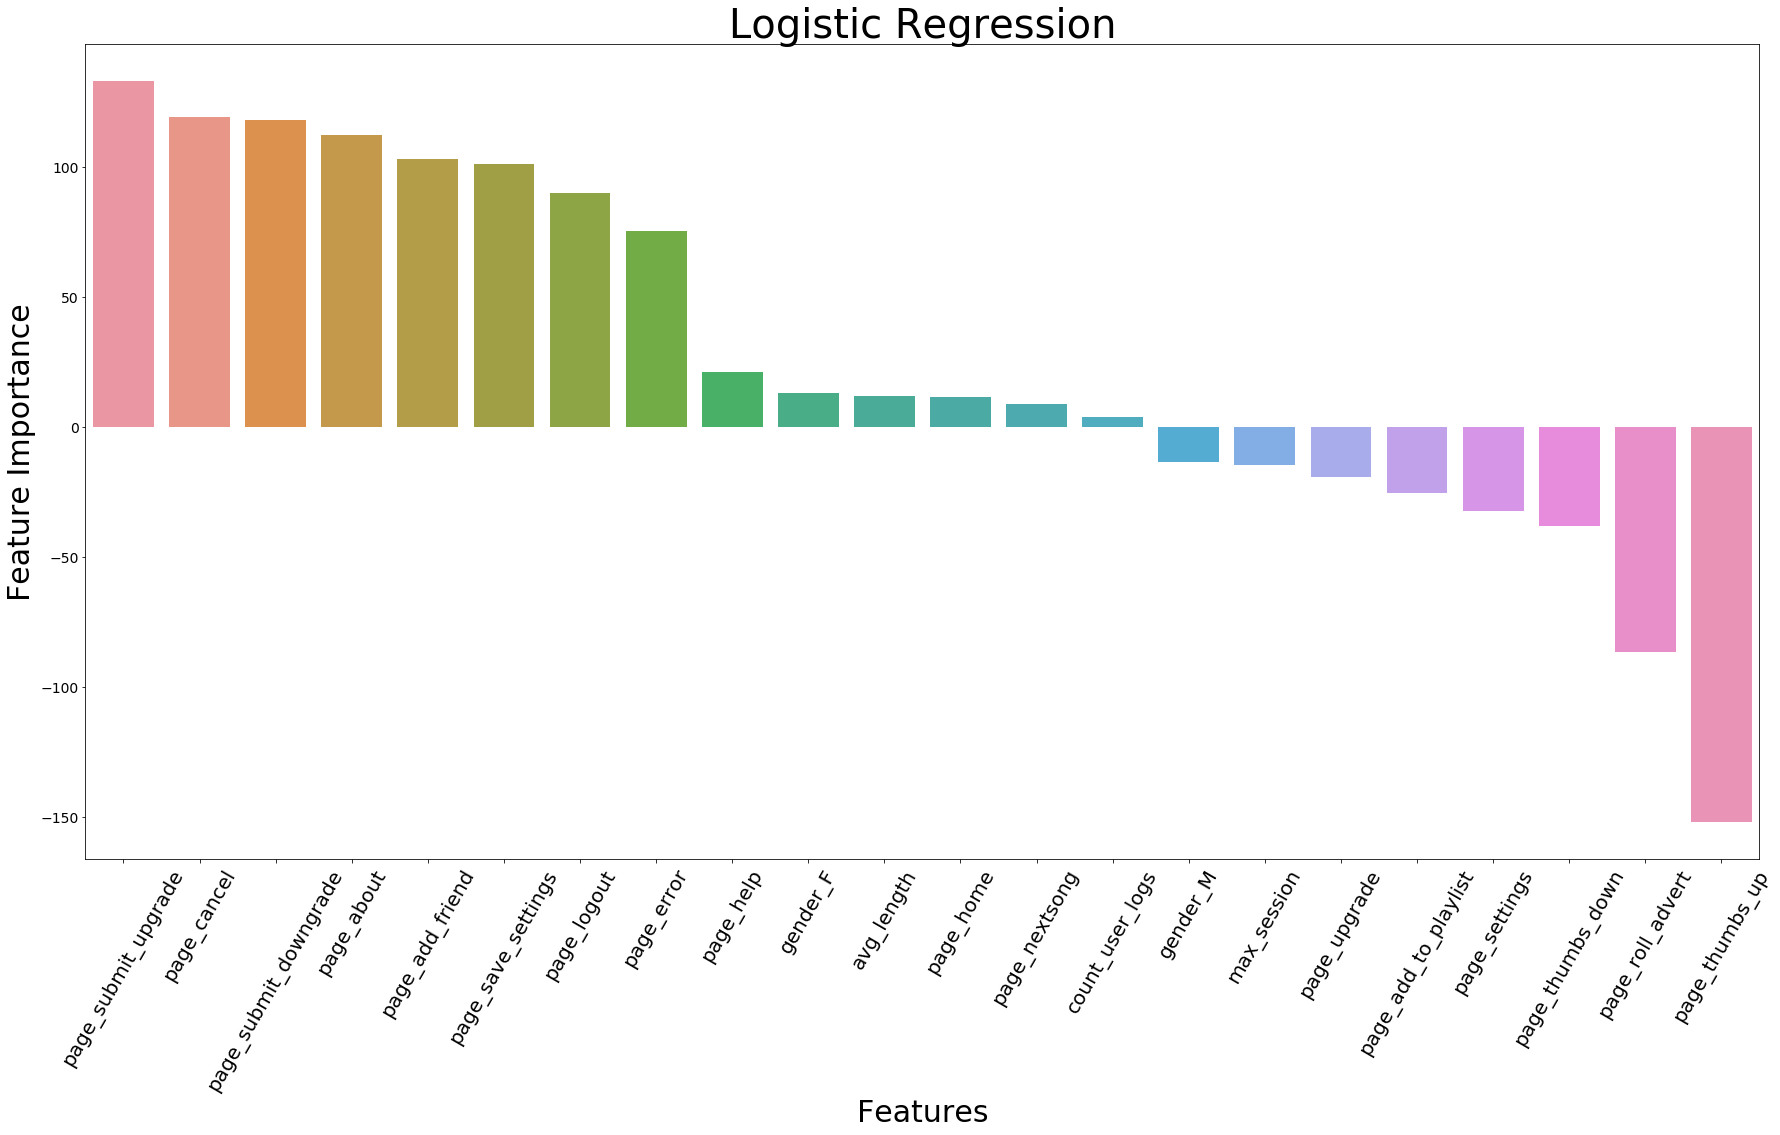

In [37]:
plot_coef(lr_df, "Logistic Regression")

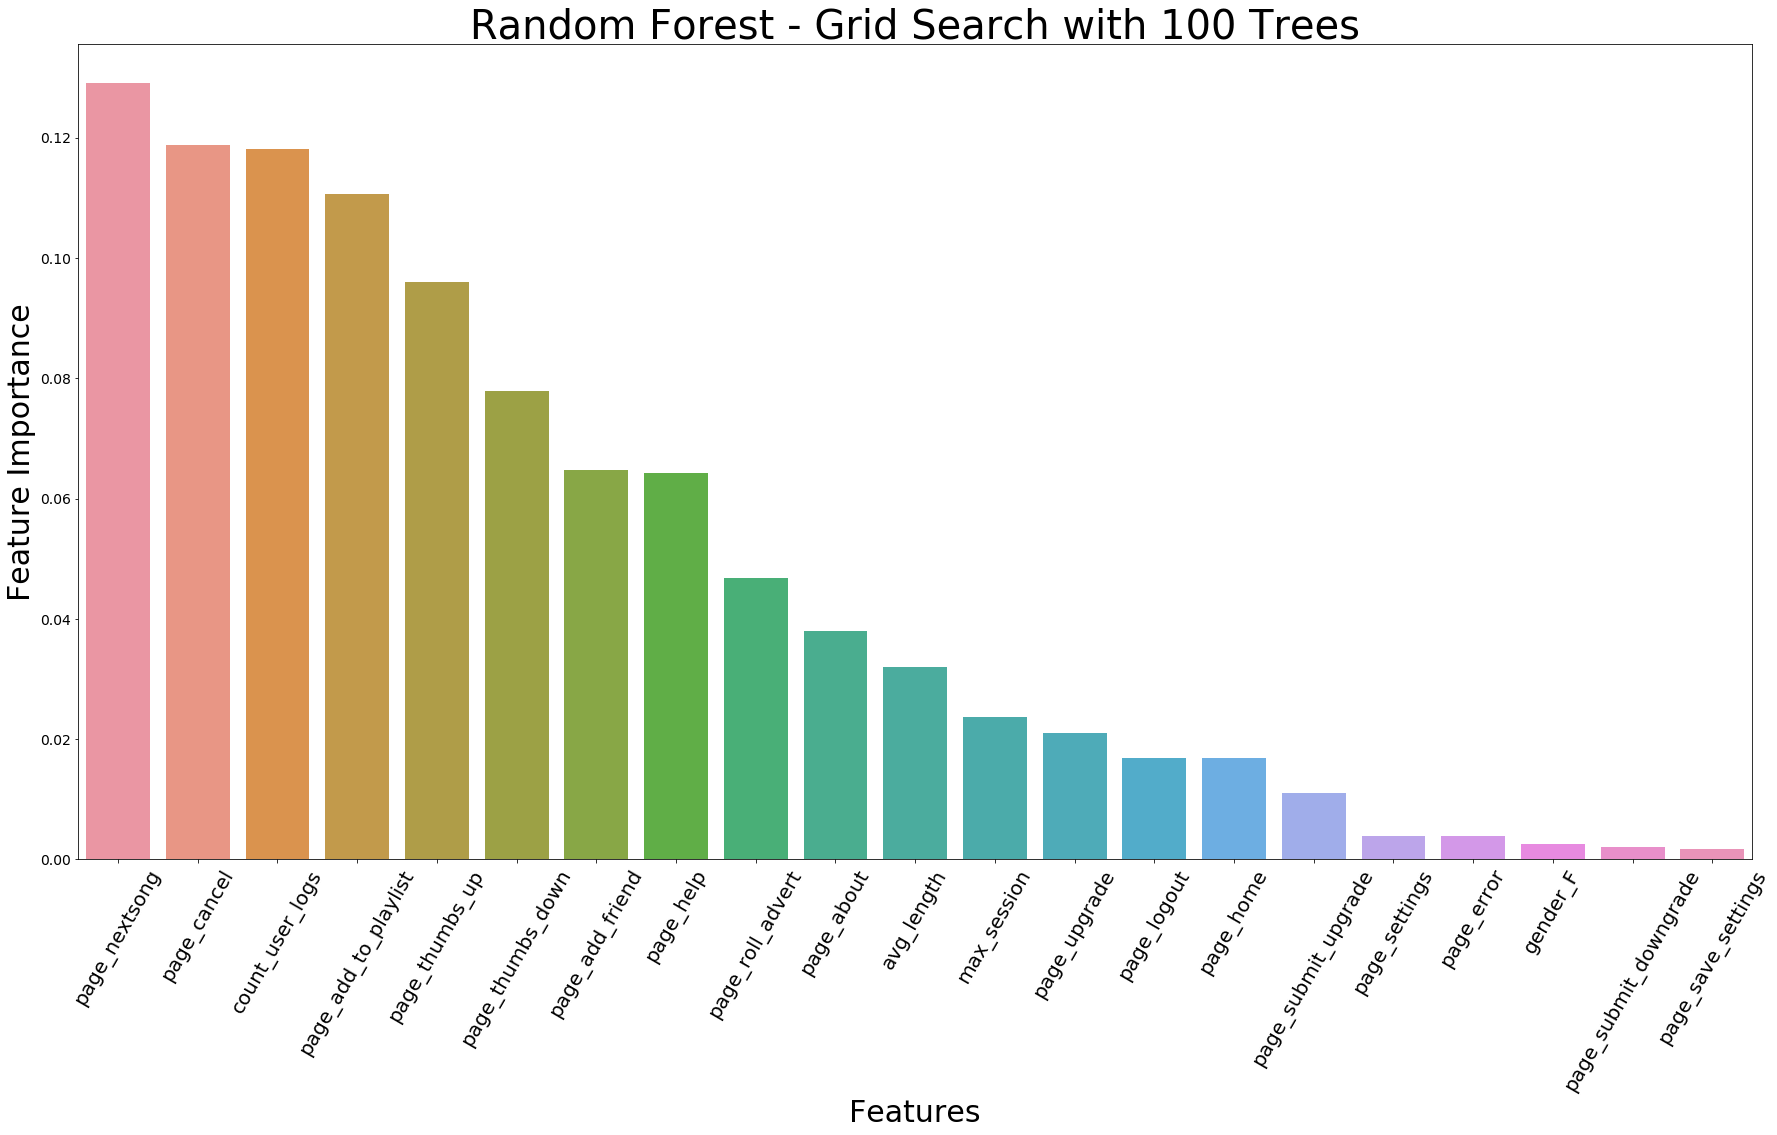

In [38]:
plot_coef(grid_df, "Random Forest - Grid Search with 100 Trees")

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

GitHub: https://github.com/chpolyzo/DSND/tree/master/Sparkify
Blog post: https://chpolyzo.medium.com/using-spark-to-predict-churn-76e02a245027 

In [44]:
# save data for visualization use
data_pd = data.toPandas()
location_pd = location_df.toPandas() 
    
pages_pd = pages_df.toPandas()

status_pd = status_df.toPandas()

auth_pd = auth_df.toPandas()
gender_pd = gender_df.toPandas()
level_pd = level_df.toPandas()
method_pd = method_df.toPandas()

churn_pd = churn_vals.toPandas()

In [45]:
data_pd.to_csv('data.csv', index = False)
location_pd.to_csv('locations.csv', index = False)
pages_pd.to_csv('pages.csv', index = False)
status_pd.to_csv('status.csv', index = False)
auth_pd.to_csv('auth.csv', index = False)
gender_pd.to_csv('gender.csv', index = False)
level_pd.to_csv('level.csv', index = False)
method_pd.to_csv('method.csv', index = False)
churn_pd.to_csv('churn.csv', index = False)